### Notebook that probes that missense mutations in degrons significantly stabilize the proteins using TCGA data.
- Figure 3d all mutations in degrons (CNA<=1)
- Figure 3e, classified by level of confidence (CNA<=1)


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats

### paths

In [2]:
base="../../" 


dataset_rppa_irls = os.path.join(base,"data/rppa_matched_irls.tsv.gz")
path_output_missense_degrons_rppa = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
path_output_indels_degrons_rppa = os.path.join(base,"data","indels_clean_type_rppa.tsv.gz")


output_path_plots = os.path.join(base,"plots/Figure3/")
role_data = os.path.join(base,"external","gene_MoA.tsv")




In [3]:
path_output_missense_degrons_rppa

'../../data/missense_clean_type_rppa.tsv.gz'

# Load rppa information from TCGA

In [4]:
df_missense_raw = pd.read_csv(path_output_missense_degrons_rppa,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_rppa_irls,sep="\t",compression="gzip")

### Filter both datasets 
- Remove Samples with alteractions upstream E3ligase
- high-level amplifications/deletions
- mutations that disrupt the epitope and desestabilizes the protein
- remove TP53 for the analysis 

### Load ROLE

In [5]:
df_roles = pd.read_csv(role_data,sep="\t")
df_roles["Hugo_Symbol"] = df_roles["gene"]
df_roles["ROLE"] = df_roles["gene_MoA"]

In [6]:
# Raw data
df_missense_raw = pd.read_csv(path_output_missense_degrons_rppa,sep="\t",compression="gzip")
df_indels_raw = pd.read_csv(path_output_indels_degrons_rppa,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_rppa_irls,sep="\t",compression="gzip")
phenotypes = ["In_Frame_Altering_Motif","In_Frame_Altering_Flanking_Degron"]
# Prepare the datasets 
# Wild type
df_wt = df_all_rppa[(df_all_rppa["Phenotype"]=="WT")&(df_all_rppa["CNA"]<=1)&(df_all_rppa["CNA"]>=-1)&(df_all_rppa["Hugo_Symbol"]!="TP53")&(~df_all_rppa["Altered_E3_Ligases"])]
df_wt["Type"] = "WT"
df_wt["DEGRON"] ="-"
df_wt["Class"] = "NON-DEGRON"
df_wt["Prob_DEGRON"] = 0.0 
df_wt["Annotated"] = "NO" 
# Other alterations
# Missense
df_missense_other = df_missense_raw[(df_missense_raw["Type_Missense"]=="Other_Missense")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_other["Type"] = "Other_Alterations"
# Indels
df_indels_other = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"]=="Other_In_Frame")&(df_indels_raw["Phenotype"].str.contains("In_Frame"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_other["Type"] = "Other_Alterations"
# Alterations degron

# missense
df_missense_degron= df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Altering_Motif")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_degron["Type"] = "Alteration_Degron"
# indel
df_indels_degron = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].isin(phenotypes))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_degron["Type"] = "Alteration_Degron"

# ALterations PTM

df_missense_ptm = df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Flanking_PTM")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=1)&(df_missense_raw["CNA"]>=-1)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_ptm["Type"] = "Alteration_Degron"
# indel
df_indels_ptm = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].str.contains("In_Frame_Altering_PTM_Flanking"))&(df_indels_raw["CNA"]<=1)&(df_indels_raw["CNA"]>=-1)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_ptm["Type"] = "Alteration_Degron"


columns = ["Type","Stability_Change","Phenotype","Matchable_Sample_ID","Protein","Prob_DEGRON","DEGRON","Class","Annotated","Hugo_Symbol"]


df_total = pd.concat([df_wt[columns],df_missense_other[columns],df_indels_other[columns],df_missense_degron[columns],df_indels_degron[columns],df_missense_ptm[columns],df_indels_ptm[columns]])
df_total = df_total.merge(df_roles[["Hugo_Symbol","ROLE"]],how="left")
df_total["ROLE"].fillna("Unknown",inplace=True)

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [8]:
df_total["Type"].unique()

array(['WT', 'Other_Alterations', 'Alteration_Degron'], dtype=object)

### Visualize the categories

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/seaborn/categorical.py:1187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


128 14 1537 428 96900 45504


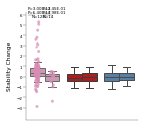

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(2, 2.)
size_strip = 3
p = {"Other_Alterations":"#cc0000","Alteration_Degron":"#d98cb3","WT":"#4682B4"}
s = ["Alteration_Degron","Other_Alterations","WT"]
hue_order = ["Act","LoF"]
proteins_query = df_total[((df_total["Type"].isin(["Alteration_Degron","Alteration_Degron_PTM"]))&(df_total["Prob_DEGRON"]>0.5))]["Protein"].unique()
data = df_total[(((df_total["Type"].isin(["Alteration_Degron"]))&(df_total["Prob_DEGRON"]>0.5))|(df_total["Phenotype"]=="WT")|(df_total["Type"]=="Other_Alterations"))&(df_total["Protein"].isin(proteins_query))]


# Plot Points for mutations altering Motif
# Missense mutations
g = sns.stripplot(data=data[(data["Type"]=="Alteration_Degron")&(data["Phenotype"]=="Missense_Mutation")],x="Type",y="Stability_Change",order=s,alpha=0.7,size=size_strip,jitter=True,dodge=True,hue="ROLE",hue_order=hue_order,palette={"Act":"#d98cb3","LoF":"#d98cb3"})
# Indels
g = sns.stripplot(data=data[(data["Type"]=="Alteration_Degron")&(data["Phenotype"].str.contains("In_Frame"))],x="Type",y="Stability_Change",order=s,alpha=0.7,size=size_strip,jitter=True,dodge=True,hue="ROLE",hue_order=hue_order,marker="^",palette={"Act":"#d98cb3","LoF":"#d98cb3"})


hue_order = ["Act","LoF"]

# Plot general boxplot
sns.boxplot(x="Type",y="Stability_Change",data=data[data["Type"]=="Alteration_Degron"],width=0.8,saturation=0.7,order=s,fliersize=0.,ax=ax, linewidth=1,whis=0.9,notch=False,hue="ROLE",hue_order=hue_order,palette={"Act":"#d98cb3","LoF":"#d98cb3"})
sns.boxplot(x="Type",y="Stability_Change",data=data[data["Type"]=="Other_Alterations"],width=0.8,saturation=0.7,order=s,fliersize=0.,ax=ax, linewidth=1,whis=0.9,notch=False,hue="ROLE",hue_order=hue_order,palette={"Act":"#cc0000","LoF":"#cc0000"})
sns.boxplot(x="Type",y="Stability_Change",data=data[data["Type"]=="WT"],width=0.8,saturation=0.7,order=s,fliersize=0.,ax=ax, linewidth=1,whis=0.9,notch=False,hue="ROLE",hue_order=hue_order,palette={"Act":"#4682B4","LoF":"#4682B4"})


# Numer of mutations motif

N_oncogene = data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="Act")].shape[0]
N_tsg = data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="LoF")].shape[0]

N_oncogene_other = data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="Act")].shape[0]
N_tsg_other = data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="LoF")].shape[0]

N_oncogene_wt = data[(data["Type"]=="WT")&(data["ROLE"]=="Act")].shape[0]
N_tsg_wt = data[(data["Type"]=="WT")&(data["ROLE"]=="LoF")].shape[0]

print (N_oncogene,N_tsg,N_oncogene_other,N_tsg_other,N_oncogene_wt,N_tsg_wt)


# Global

#N_oncogene_global = data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="oncogene")].shape[0]
#N_tsg_global = data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="TSG")].shape[0]

# Write numbers of N

maxv = np.nanmax(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values))
minv = np.nanmin(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values))

ax.text(y=maxv+0.4,x=-0.35,s="N="+str(N_oncogene),fontsize=4)
ax.text(y=maxv+0.4,x=-0.05,s="N="+str(N_tsg),fontsize=4)


# Calculate significance 
# Mutations motifs

pvalue_oncogenes_other = stats.mannwhitneyu(data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="Act")]["Stability_Change"].values,data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="Act")]["Stability_Change"].values)[1]
pvalue_oncogenes_wt = stats.mannwhitneyu(data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="Act")]["Stability_Change"].values,data[(data["Type"]=="WT")&(data["ROLE"]=="Act")]["Stability_Change"].values)[1]



ax.axhline(y=maxv+0.7,xmin=0.02,xmax=0.08,color="black",linewidth=0.25)
if pvalue_oncogenes_wt < 0.05:
    ax.text(y=maxv+1.2,x=-0.45,s="P="+str("{0:.2E}".format(pvalue_oncogenes_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=-0.45,s="P=n.s.",fontsize=4)

if pvalue_oncogenes_other < 0.05:
    ax.text(y=maxv+0.8,x=-0.45,s="P="+str("{0:.2E}".format(pvalue_oncogenes_other)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=-0.45,s="P=n.s.",fontsize=4)


    
    
# Mutations outside

pvalue_TSG_other = stats.mannwhitneyu(data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="LoF")]["Stability_Change"].values,data[(data["Type"]=="Other_Alterations")&(data["ROLE"]=="LoF")]["Stability_Change"].values)[1]
pvalue_TSG_wt = stats.mannwhitneyu(data[(data["Type"]=="Alteration_Degron")&(data["ROLE"]=="LoF")]["Stability_Change"].values,data[(data["Type"]=="WT")&(data["ROLE"]=="LoF")]["Stability_Change"].values)[1]



ax.axhline(y=maxv+0.7,xmin=0.15,xmax=0.23,color="black",linewidth=0.25)

ax.text(y=maxv+1.2,x=-0.05,s="P="+str("{0:.2E}".format(pvalue_TSG_wt)),fontsize=4)

ax.text(y=maxv+0.8,x=-0.05,s="P="+str("{0:.2E}".format(pvalue_TSG_other)),fontsize=4)



ax.set_ylabel("Stability Change",fontsize=6)
ax.set_xlabel("",fontsize=6)
ax.set_xticks([])

ylim = (-3,6)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(ylim[0],ylim[1]+1,1)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =6  , pad=0.5 ,width=0.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.get_legend().remove()
ax.set_ylim(minv-0.5,maxv+1)
plt.savefig(output_path_plots+"/Figure_boxplot_role_CNA1.pdf",bbox_inches="tight")